In [1]:
import tensorflow as tf

In [2]:
%load_ext tensorboard
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
print(tf.__version__)

2.6.0


In [3]:
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os, cv2

In [4]:
print(os.getcwd())

/home/user/AI_2/Gender-Detection-master


In [5]:
#%cd "C:\\Users\\PC\\Desktop\\AI_World\\AI_Projects\\masksdetection_master"

os.chdir('/home/user/AI_2/Gender-Detection-master')
print(os.getcwd())

/home/user/AI_2/Gender-Detection-master


In [6]:
imgpath = "/home/user/AI_2/Gender-Detection-master/gender_dataset_face/man/face_1.jpg"
img = cv2.imread(imgpath,1)

In [7]:
img.shape

(146, 106, 3)

In [8]:
# For Jupyter Notebook users:
#cv2.imshow("NoseMask", img)  # Here, "Penguin" is the name that'll be given to the window
 
# waiting for key event
#cv2.waitKey(0)

# destroying all windows
#cv2.destroyAllWindows()

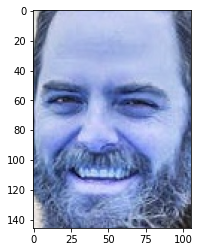

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [10]:
# construct the argument parser and parse the arguments
dataset_path=os.getcwd()+"/gender_dataset_face"
model_path=os.getcwd()+"/model/gender_model"
plot_path=os.getcwd()+"/plot"
dataset_path

'/home/user/AI_2/Gender-Detection-master/gender_dataset_face'

In [11]:
train_test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
train_test_ds = train_test_gen.flow_from_directory(
    dataset_path,
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

Found 2307 images belonging to 2 classes.


In [13]:
# learning rate, number of epochs and batch size
learning_rate = 1e-4
epochs        = 50
batch_size    = 32

In [14]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images paths...")
imagePaths = list(paths.list_images(dataset_path))
#imagePaths = [imagePath.replace("\\","//",-1) for imagePath in imagePaths]
print("[INFO] loading images complete")
data   = []
labels = []

[INFO] loading images paths...
[INFO] loading images complete


In [15]:
#imagePaths

In [16]:
# number of mask images
len(os.listdir(dataset_path + "/man"))

1173

In [17]:
# number of no mask images
len(os.listdir(dataset_path + "/woman"))

1134

In [18]:
# loop over the image paths
print("[INFO] Getting images from image path ...")
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split("/")[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
print("[INFO] Getting image complete")

[INFO] Getting images from image path ...
[INFO] Getting image complete


In [19]:
# convert the data and labels to NumPy arrays
data   = np.array(data, dtype="float32")
labels = np.array(labels)
data.shape

(2307, 224, 224, 3)

In [20]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
#labels

In [21]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [22]:
#help(train_test_split)

In [23]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [48]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [57]:
!rm -rf ./logs/

In [58]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [59]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [60]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [61]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate = learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [62]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback   = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', 
                                       baseline=None, restore_best_weights=True)

2021-12-04 23:03:22.113282: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-04 23:03:22.113377: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-04 23:03:22.114860: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [63]:
!pwd

/home/user/AI_2/Gender-Detection-master


In [64]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=epochs,callbacks=[tensorboard_callback, earlystopping_callback])
print("[INFO] training head finish")

[INFO] training head...
Epoch 1/50
 1/57 [..............................] - ETA: 4:12 - loss: 0.8369 - accuracy: 0.4688

2021-12-04 23:03:28.633466: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-04 23:03:28.633503: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.



 2/57 [>.............................] - ETA: 48s - loss: 0.8732 - accuracy: 0.5312 

2021-12-04 23:03:29.667431: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-04 23:03:29.673598: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-04 23:03:29.678972: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20211204-230322/train/plugins/profile/2021_12_04_23_03_29

2021-12-04 23:03:29.682542: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20211204-230322/train/plugins/profile/2021_12_04_23_03_29/Welcome.trace.json.gz
2021-12-04 23:03:29.693290: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20211204-230322/train/plugins/profile/2021_12_04_23_03_29

2021-12-04 23:03:29.695726: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/20211204-230322/train/plugins/profile/2021_12_04_23_03_29/Welcom

57/57 [==============================] - 62s 1s/step - loss: 0.5374 - accuracy: 0.7562 - val_loss: 0.3698 - val_accuracy: 0.8398
Epoch 2/50
57/57 [==============================] - 57s 997ms/step - loss: 0.3629 - accuracy: 0.8461 - val_loss: 0.3364 - val_accuracy: 0.8442
Epoch 3/50
57/57 [==============================] - 55s 966ms/step - loss: 0.3108 - accuracy: 0.8798 - val_loss: 0.3022 - val_accuracy: 0.8636
Epoch 4/50
57/57 [==============================] - 61s 1s/step - loss: 0.2896 - accuracy: 0.8847 - val_loss: 0.2815 - val_accuracy: 0.8788
Epoch 5/50
57/57 [==============================] - 52s 916ms/step - loss: 0.2889 - accuracy: 0.8814 - val_loss: 0.2822 - val_accuracy: 0.8788
Epoch 6/50
57/57 [==============================] - 51s 892ms/step - loss: 0.2688 - accuracy: 0.8908 - val_loss: 0.2410 - val_accuracy: 0.8961
Epoch 7/50
57/57 [==============================] - 54s 955ms/step - loss: 0.2503 - accuracy: 0.8897 - val_loss: 0.2398 - val_accuracy: 0.9069
Epoch 8/50
57/57

In [65]:
%tensorboard --logdir logs

In [66]:
model.evaluate(trainX, trainY)

58/58 [==============================] - 27s 442ms/step - loss: 0.1722 - accuracy: 0.9312


[0.17218191921710968, 0.931165337562561]

In [68]:
model.evaluate(testX, testY)

15/15 [==============================] - 6s 418ms/step - loss: 0.1814 - accuracy: 0.9264


[0.18142089247703552, 0.9264069199562073]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


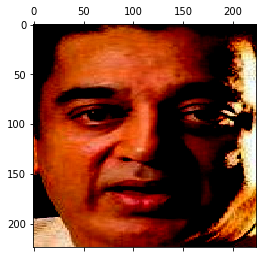

In [69]:
plt.matshow(testX[50])

In [70]:
testY[108]

array([1., 0.], dtype=float32)

In [72]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)

[INFO] evaluating network...


In [73]:
predIdxs.shape

(462, 2)

In [74]:
classLables = ['man', 'woman']


In [75]:
test_y = np.array([np.argmax(ii) for ii in testY])
test_y

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [76]:
y_predict_labels = np.array([np.argmax(ii) for ii in predIdxs])
y_predict_labels

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,

In [77]:
cm = tf.math.confusion_matrix(labels=test_y, predictions = y_predict_labels)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[219,  16],
       [ 18, 209]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

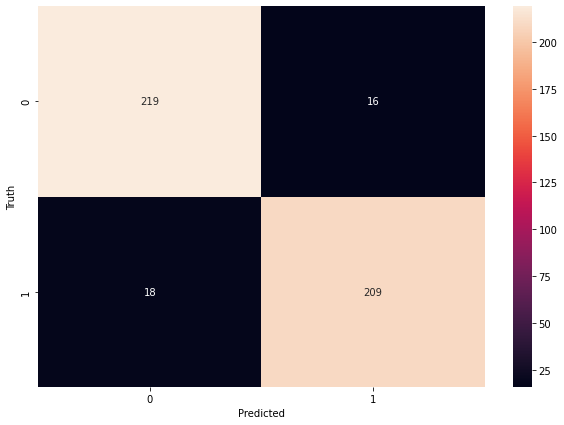

In [78]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [79]:
len(testX)

462

In [80]:
#random.randint(0, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

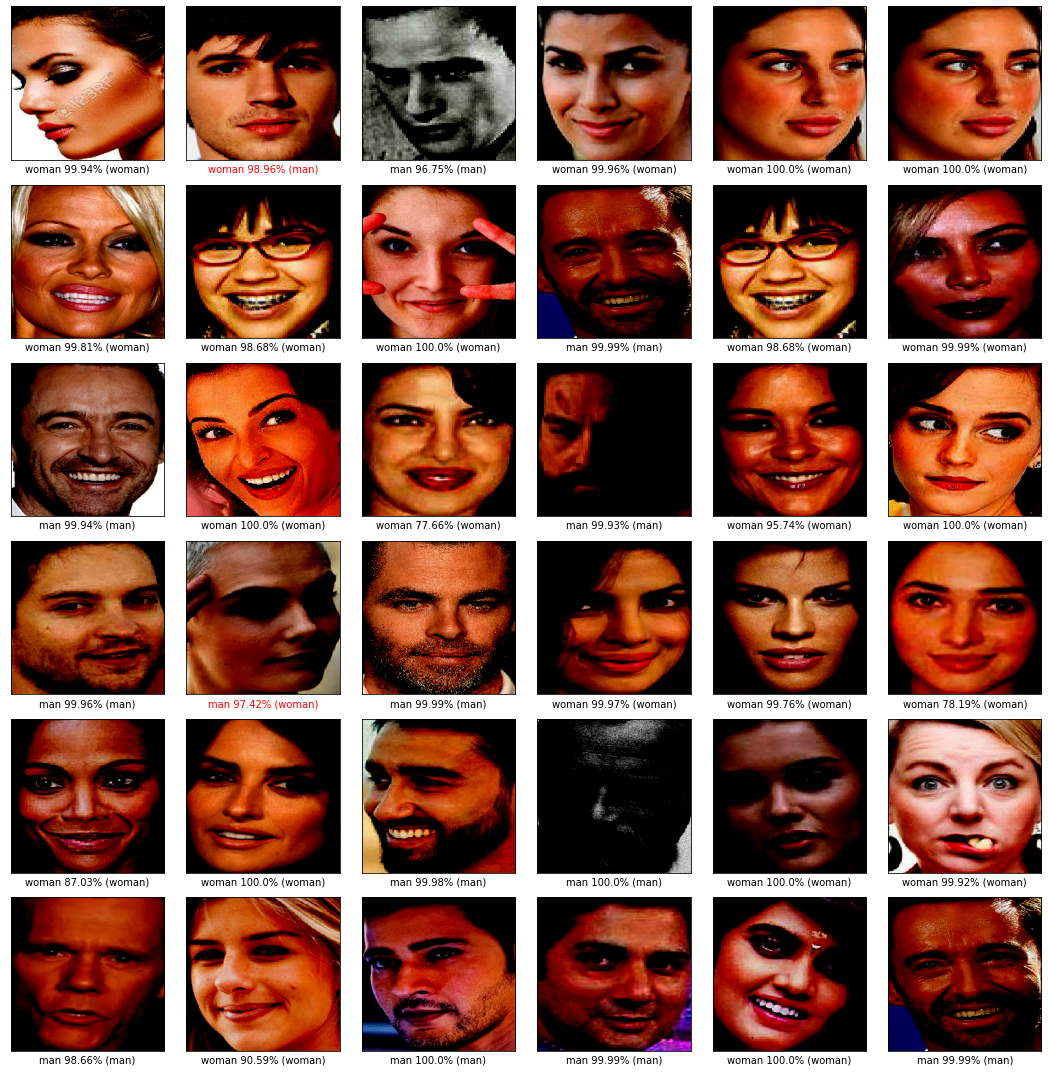

In [81]:
import random
plt.figure(figsize=(15,15))
nn = 36
for ii in range(0, nn):
  plt.subplot(6,6,ii+1)
  plt.xticks([])
  plt.yticks([])
  randno = random.randint(0, (len(testX)-1))
  plt.imshow(testX[randno])
  plt.tight_layout()
  if y_predict_labels[randno] == test_y[randno]:
    color = 'black'
  else:
    color = 'red'
  plt.xlabel(classLables[y_predict_labels[randno]] + " " + str(round(100*np.max(predIdxs[randno]), 2)) + "%"  + " " + "("+classLables[test_y[randno]]+")", color = color)

In [82]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs.argmax(axis=1), target_names = classLables))

              precision    recall  f1-score   support

         man       0.92      0.93      0.93       235
       woman       0.93      0.92      0.92       227

    accuracy                           0.93       462
   macro avg       0.93      0.93      0.93       462
weighted avg       0.93      0.93      0.93       462



In [83]:
# serialize the model to disk
print("[INFO] saving gender detector model... path: %s"%(model_path+".h5"))
model.save(model_path+".h5")  #h5 format

[INFO] saving gender detector model... path: /home/user/AI_2/Gender-Detection-master/model/gender_model.h5


/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [84]:
model.save(model_path)

2021-12-04 23:35:29.367399: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/user/AI_2/Gender-Detection-master/model/gender_model/assets


/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [85]:
model_path

'/home/user/AI_2/Gender-Detection-master/model/gender_model'

In [92]:
os.getcwd()

'/home/user/AI_2/Gender-Detection-master'

In [87]:
#os.makedirs(plot_path)
#os.chdir(plot_path)

In [93]:
## Loading the model from the saved location
loaded_model = tf.keras.models.load_model("model/gender_model")

## check architecture
loaded_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
## next is to convert the h5 file to js. Check the text editor for code and run on terminal